In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
import random

In [2]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

## Load Data

### Load MAI2021 ISP Dataset
- https://github.com/MediaTek-NeuroPilot/mai21-learned-smartphone-isp

In [3]:
from datasets.mai import MaiLoader

base_dir = "/home/gosha20777/MAI2021"
train_input_dir = os.path.join(base_dir, "mediatek_raw")
train_target_dir = os.path.join(base_dir, "fujifilm")
img_size = (128, 128)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png")
    ]
)


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))
    

val_samples = 20000
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
target_train_gen = MaiLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
target_val_gen = MaiLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)

print("Number of samples:", len(input_img_paths))
print("Number train batches:", len(target_train_gen))
print("Number val batches:", len(target_val_gen))

0.png | 0.png
1.png | 1.png
10.png | 10.png
100.png | 100.png
1000.png | 1000.png
10000.png | 10000.png
10001.png | 10001.png
10002.png | 10002.png
10003.png | 10003.png
10004.png | 10004.png
Number of samples: 24161
Number train batches: 520
Number val batches: 2500


## Fine-Tune U-Net Trained on Source Domain

In [4]:
from losses.losses import mssim, vgg_loss

def target_loss(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

In [6]:
from models import encoder, unet, domain_classifyer, dann

t_encoder = encoder.get_model()
t_encoder.load_weights('s_encoder_zurich.h5')
u_net = unet.get_model()
u_net.load_weights('s_u_net_zurich.h5')

t_model = dann.SingleNet(
    encoder=t_encoder,
    u_net=u_net
)

### Train

In [7]:
t_model.compile(optimizer="adam", loss_fn=target_loss, metrics=[psnr, ssim])

epochs = 4

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/target_mai")
]

history = t_model.fit(
    target_train_gen, epochs=epochs, validation_data=target_val_gen, callbacks=callbacks, workers=8
)

Epoch 1/4
520/520 [==============================] - 108s 172ms/step - psnr: 19.9005 - ssim: 0.7378 - source_loss: 0.0787 - val_psnr: 21.9610 - val_ssim: 0.8063 - val_source_loss: 0.0782
Epoch 2/4
520/520 [==============================] - 89s 172ms/step - psnr: 22.2326 - ssim: 0.8105 - source_loss: 0.0700 - val_psnr: 22.4538 - val_ssim: 0.8138 - val_source_loss: 0.0690
Epoch 3/4
520/520 [==============================] - 90s 173ms/step - psnr: 22.4242 - ssim: 0.8199 - source_loss: 0.0687 - val_psnr: 22.5437 - val_ssim: 0.8190 - val_source_loss: 0.0641
Epoch 4/4
520/520 [==============================] - 91s 174ms/step - psnr: 22.1649 - ssim: 0.8152 - source_loss: 0.0688 - val_psnr: 22.6139 - val_ssim: 0.8267 - val_source_loss: 0.0617


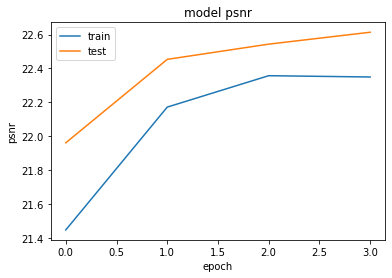

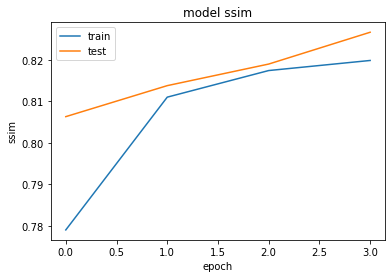

In [8]:
# summarize history for psnr
plt.plot(history.history['psnr'])
plt.plot(history.history['val_psnr'])
plt.title('model psnr')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for ssim
plt.plot(history.history['ssim'])
plt.plot(history.history['val_ssim'])
plt.title('model ssim')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save

In [9]:
t_encoder.save('t_mai_encoder.h5')
u_net.save('t_mai_u_net.h5')

### Evaluate

In [11]:
print("Evaluate on test data")
psnr_val, ssim_val, _ = t_model.evaluate(target_val_gen)
print(f"psnr: {psnr_val}, ssim: {ssim_val}")

Evaluate on test data
2500/2500 [==============================] - 67s 27ms/step - psnr: 22.6139 - ssim: 0.8267 - source_loss: 0.0666 10s - psnr: 22.6157 - ssim: 0.8265 - source_loss: 0.06 - ETA: 10s - - ETA:
psnr: 22.613935470581055, ssim: 0.8267057538032532


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


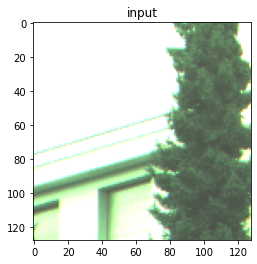

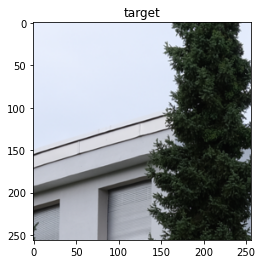

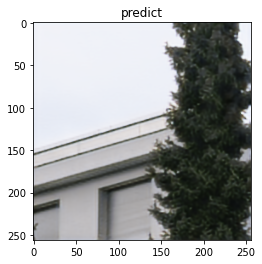

In [12]:
x, y = target_val_gen.__getitem__(0)
preds = t_model.predict(x)
plt_display(x[0][:,:,0:3], 'input')
plt_display(y[0], 'target')
plt_display(preds[0], 'predict')